### Test multiple different architechtures for NCA based diffusers, on the square dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models.embeddings import TimestepEmbedding

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Things to test

* NCA that predicts noise in a single step
* NCA that predicts noise in multiple steps

Single step is less expressive, but denoising process is also in steps. 
___

* Maybe also, up pool and down pool after NCA. Since NCA do not care about image size. But if the same NCA is used in all layers then, it might need to use a compression embedding for how many factors the image is reduced by.
* Try varying depth and width of the NCA.

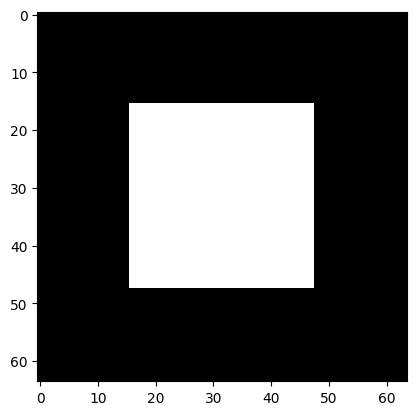

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, 1, image_size, image_size), device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

In [11]:
# From https://github.com/miltonllera/jax-growing-ncas/blob/master/scripts/emojis.py
#   optim = optax.chain(
#         optax.clip_by_global_norm(1.0),
#         optax.adamw(lr_or_schedule),
#         # optax.adam(optax.piecewise_constant_schedule(lr, {2000: 0.1})),
#     )

class NCAD(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCAD, self).__init__()

        self.inchannels = in_channels
        self.inchannels = out_channels

        #Not sure if the timestep embedding makes sense for the single forward pass,
        # as information won't get propagted through out the height and width dimensions.

        # I need to look into how timestep embeddings are normally used in diffusion models.

        timestepEmbedSize = 8
        self.timestepEmbedding = TimestepEmbedding(in_channels=1, time_embed_dim=timestepEmbedSize)
        self.conv1 = nn.Conv2d(in_channels + timestepEmbedSize, 16, kernel_size=3, padding=1)  # 3x3 convolution
        self.conv2 = nn.Conv2d(16, 16, kernel_size=1)           # 1x1 convolution
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=1) # 1x1 convolution

    def forward(self, x, t):
        bs, ch, height, width = x.shape

        timeEmbedding = self.timestepEmbedding(t) 
        timeEmbedding = timeEmbedding.view(bs, -1, 1, 1)  # batchsize, possibly already handled in TimestepEmbedding
        timeEmbedding = timeEmbedding.expand(-1, -1, height, width)

        x = torch.cat([x, timeEmbedding], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.sigmoid(x)
        return x
    
    def infer(self, x, steps, t):
        for i in range(steps):
            x = self.forward(x, t)
        return x
    

class DeepNCAD(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeepNCAD, self).__init__()

        self.inchannels = in_channels
        self.inchannels = out_channels

        #Not sure if the timestep embedding makes sense for the single forward pass,
        # as information won't get propagted through out the height and width dimensions.

        # I need to look into how timestep embeddings are normally used in diffusion models.

        timestepEmbedSize = 8
        self.timestepEmbedding = TimestepEmbedding(in_channels=1, time_embed_dim=timestepEmbedSize)

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels + timestepEmbedSize, 16, kernel_size=3, padding=1),  # 3x3 convolution
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=1), # 1x1 convolution
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1), # 1x1 convolution
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1), # 1x1 convolution
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=1), # 1x1 convolution
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size=1), # 1x1 convolution
            nn.Sigmoid()
        )

    def forward(self, x, t):
        bs, ch, height, width = x.shape

        timeEmbedding = self.timestepEmbedding(t) 
        timeEmbedding = timeEmbedding.view(bs, -1, 1, 1)  # batchsize, possibly already handled in TimestepEmbedding
        timeEmbedding = timeEmbedding.expand(-1, -1, height, width)

        x = torch.cat([x, timeEmbedding], dim=1)
        x = self.convs(x)
        return x
    
    def infer(self, x, steps, t):
        for i in range(steps):
            x = self.forward(x, t)
        return x

In [12]:
# singleStepModel = NCAD(1, 1).to(device)
# multiStepModel = NCAD(1, 1).to(device)

# singleOp = torch.optim.Adam(singleStepModel.parameters(), lr=1e-4)
# multiOp = torch.optim.Adam(multiStepModel.parameters(), lr=1e-4)

deepModel = DeepNCAD(1, 1).to(device)
manyStepModel = NCAD(1, 1).to(device)

deepOp = torch.optim.Adam(deepModel.parameters(), lr=1e-4)
manyOp = torch.optim.Adam(manyStepModel.parameters(), lr=1e-4)

diffusionSteps = 100 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

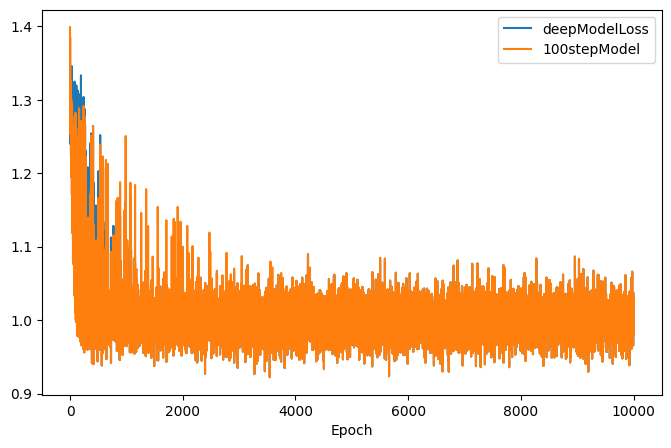

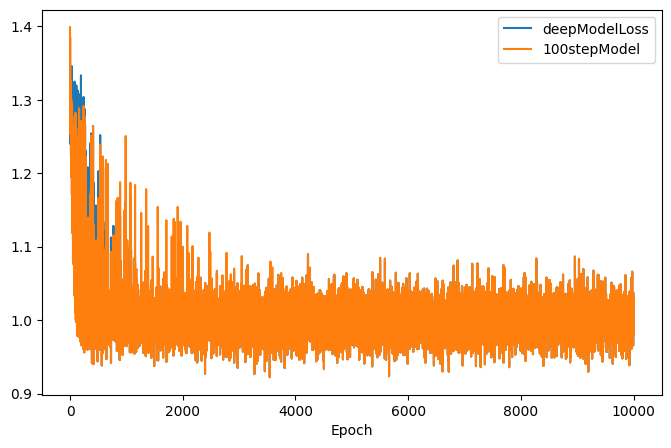

In [13]:
deepModel.train()
manyStepModel.train()

epochs = 10001
# losses = {
#     'singleStepLoss': [],
#     'multiStepLoss': [],
# }
losses['deepModelLoss'] = []
losses['100stepModel'] = []

fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

for epoch in range(epochs):
    deepOp.zero_grad()
    manyOp.zero_grad()
    
    #Should try batch training
    t = torch.randint(0, diffusionSteps, (image.shape[0],), device=device).float()
    noise = torch.randn_like(image, device=device)
    noisyImage = scheduler.add_noise(image, noise, t.long())

    singlePred = deepModel.infer(noisyImage, 20, t)
    multiPred = manyStepModel.infer(noisyImage, 100, t)

    singleLoss = F.mse_loss(singlePred, noise)
    singleLoss.backward()
    deepOp.step()
    multiLoss = F.mse_loss(multiPred, noise)
    multiLoss.backward()
    manyOp.step()

    losses['deepModelLoss'].append(singleLoss.item())
    losses['100stepModel'].append(multiLoss.item())
    
    if epoch % 50 == 0:
        clear_output(wait=True)  
        ax.clear()
        plt.plot(losses["deepModelLoss"], label=f'deepModelLoss')
        plt.plot(losses["100stepModel"], label=f'100stepModel')
        plt.legend()
        plt.xlabel('Epoch')
        display(fig)
clear_output(wait=True)  
ax.clear()
plt.plot(losses["deepModelLoss"], label=f'deepModelLoss')
plt.plot(losses["100stepModel"], label=f'100stepModel')
plt.legend()
plt.xlabel('Epoch')
display(fig)

Text(0.5, 0, 'Epoch')

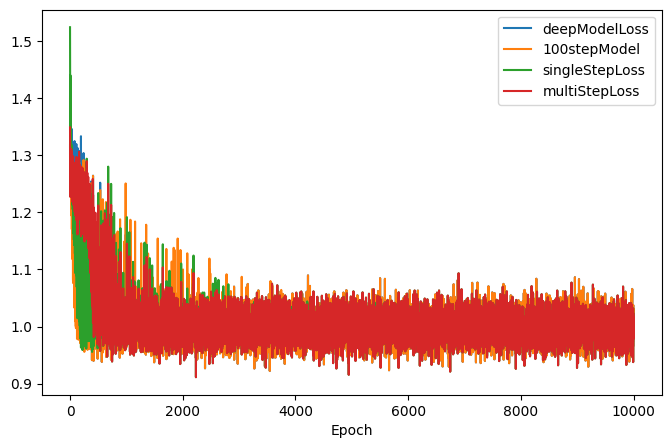

In [16]:

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses["deepModelLoss"], label=f'deepModelLoss')
plt.plot(losses["100stepModel"], label=f'100stepModel')
plt.plot(losses["singleStepLoss"], label=f'singleStepLoss')
plt.plot(losses["multiStepLoss"], label=f'multiStepLoss')
plt.legend()
plt.xlabel('Epoch')

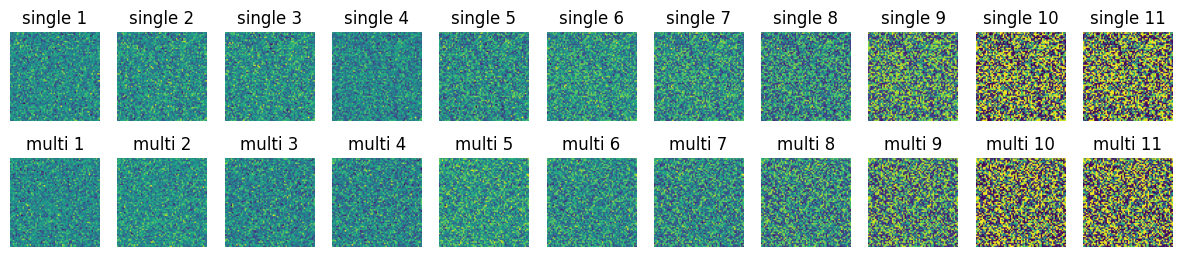

In [8]:
# Inference of trained models 

singleStepModel.eval()
multiStepModel.eval()

inferenceSteps = 20
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    multiX = singleX.clone()
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = singleStepModel.infer(singleX, 1, timeTensor)
        multiOut = multiStepModel.infer(multiX, 20, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample
        multiX = scheduler.step(multiOut, t, multiX).prev_sample

        if i % 2:
            intermediateImages['single'].append(singleX.cpu().numpy())
            intermediateImages['multi'].append(multiX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())
    intermediateImages['multi'].append(multiX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(2, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single', 'multi']):
    for col, img in enumerate(intermediateImages[key]):
        axs[row, col].imshow(img[0,0])
        axs[row, col].axis('off')  
        axs[row, col].set_title(f"{key} {col+1}")  
